# DBInfer-Bench Dataset Guide

DBInfer-Bench is a collection of benchmarks for evaluating the predictive capability of machine learning solutions over data stored as multiple tables, of which the core is the dataset definition. This tutorial introduces the basic usages of datasets including how to load, access and analyze them.

To load a built-in dataset, use the `load_rdb_data` API.

In [1]:
import dbinfer_bench as dbb
dataset = dbb.load_rdb_data('diginetica')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 322M/322M [00:03<00:00, 98.4MB/s]


Extracting datasets/20240304-diginetica.tar ...


At high-level, each dataset contains three types of data:
* *Metadata* that contains schema information of each table (e.g., column data type), table relationships, etc.
* *Table data* that stores the table contents.
* *Task data* that represents the intended tasks to be solved over the dataset.

We will go over them one-by-one.

## Metadata

Metadata is accessible via the `metadata` property, which inherits [PyDantic Model](https://docs.pydantic.dev/latest/concepts/models/). You can print it in JSON or YAML format to view its content.

In [2]:
import json
print(dataset.metadata.json(indent=2))

{
  "dataset_name": "diginetica",
  "tables": [
    {
      "name": "Product",
      "source": "data/products.pqt",
      "format": "parquet",
      "columns": [
        {
          "name": "itemId",
          "dtype": "primary_key"
        },
        {
          "name": "categoryId",
          "dtype": "category"
        },
        {
          "name": "pricelog2",
          "dtype": "float"
        }
      ],
      "time_column": null
    },
    {
      "name": "Click",
      "source": "data/clicks.pqt",
      "format": "parquet",
      "columns": [
        {
          "name": "queryId",
          "dtype": "foreign_key",
          "link_to": "Query.queryId"
        },
        {
          "name": "itemId",
          "dtype": "foreign_key",
          "link_to": "Product.itemId"
        },
        {
          "name": "timestamp",
          "dtype": "datetime"
        }
      ],
      "time_column": "timestamp"
    },
    {
      "name": "QueryResult",
      "source": "data/query_results.

Accessing its attributes is easy as it is just like accessing a normal python class. Below are some examples:

In [3]:
metadata = dataset.metadata
print(metadata.dataset_name)           # Dataset name.
print(metadata.tables[0].name)         # Name of the first table.
print(metadata.tables[0].columns[0])   # Schema of the first column of the first table.

diginetica
Product
name='itemId' dtype='primary_key'


Most of the attributes are self-explained. Formal definition can be found [here](https://github.com/awslabs/multi-table-benchmark/blob/main/dbinfer_bench/dataset_meta.py). You can also plot the RDB schema using the `sqlalchemy_schemadisplay` package.

In [4]:
# Uncomment to install the required package.
#!pip install sqlalchemy_schemadisplay

In [5]:
from sqlalchemy import create_engine
from sqlalchemy_schemadisplay import create_schema_graph
# Use the sqlalchemy_metadata attribute to get metadata in sqlalchemy format.
sa_metadata = dataset.sqlalchemy_metadata
graph = create_schema_graph(engine=create_engine('sqlite://'),  # Use a temporary in-memory sqlite db.
                            metadata=sa_metadata,
                            show_datatypes=True,                # The image would show datatypes
                            show_indexes=True,                  # The image would show index names and unique constraints
                            rankdir='LR',                       # From left to right, instead of top to bottom
                            concentrate=False)                  # Don't try to join the relation lines together

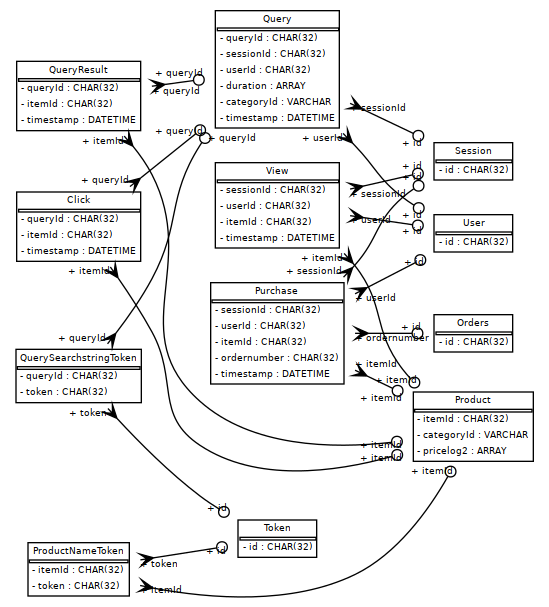

In [6]:
from IPython.display import Image, display

plt = Image(graph.create_png())
display(plt)

Note that in the schema graph above, `Session`, `User`, `Orders` and `Token` tables are not explicitly defined in the dataset. Instead, they are referenced by some foreign keys (using the `link_to` attribute). These *missing* tables are very common in real-world scenarios and we expect ML solutions to handle them properly.

## Tables

Tables are accessible via the `tables` attribute. Each table is a collection of columns, thus stored as a dictionary of NumPy arrays.

In [7]:
print(dataset.tables['Query'])

{'queryId': array([     1,      2,      4, ..., 980498, 980500, 980503]), 'sessionId': array([     1,      2,      4, ..., 168396,  13265, 600687]), 'userId': array([    nan,     nan,     nan, ...,     nan,     nan, 249347.]), 'duration': array([ 311,  314, 1092, ..., 2208, 1203,  169]), 'categoryId': array([  0,   0,   0, ..., 389, 257, 305]), 'timestamp': array(['2016-05-09T12:26:37.709000000', '2016-05-09T12:27:47.315000000',
       '2016-05-09T12:24:39.459000000', ...,
       '2016-03-25T20:49:29.220000000', '2016-04-14T16:47:16.115000000',
       '2016-02-16T11:41:51.722000000'], dtype='datetime64[ns]')}


The choice of NumPy array dictionary makes it easier to support vector embeddings. In other cases, using `pandas.DataFrame` can be more convenient for analysis.

In [8]:
import pandas as pd
query_df = pd.DataFrame(dataset.tables['Query'])
print(query_df)

        queryId  sessionId    userId  duration  categoryId  \
0             1          1       NaN       311           0   
1             2          2       NaN       314           0   
2             4          4       NaN      1092           0   
3             5          5       NaN       266           0   
4             6          6       NaN       673           0   
...         ...        ...       ...       ...         ...   
636155   980495     469303  189994.0       886         444   
636156   980496     156138       NaN       852         755   
636157   980498     168396       NaN      2208         389   
636158   980500      13265       NaN      1203         257   
636159   980503     600687  249347.0       169         305   

                     timestamp  
0      2016-05-09 12:26:37.709  
1      2016-05-09 12:27:47.315  
2      2016-05-09 12:24:39.459  
3      2016-05-09 09:01:58.186  
4      2016-05-09 10:57:47.335  
...                        ...  
636155 2016-02-24 18:19:

## Tasks

DBInfer-Bench tests the capability of ML solutions to predict the values of a target column in a target table given the entire RDB data. Based on the semantics of the target column, the prediction task can be further mapped to three kinds:
* *Classification* task if the target column contains categorical values. Typical evaluation metrics: accuracy, auroc.
* *Regression* task if the target column contains floating values. Typical evaluation metrics: rmse, mae.
* *Retrieval* task if the target column contains foreign keys. Typical evaluation metrics: mrr@k, hit@k.

Each dataset can have one or many associated tasks, since we encourage solutions that are competitive across different settings. Use `dataset.tasks` to get the list of pre-defined tasks or use `dataset.get_task(name)` to get a task by its name:

In [9]:
print('Number of tasks:', len(dataset.tasks))
ctr_task = dataset.get_task('ctr')

Number of tasks: 2


Use `task.metadata` to access its metadata.

In [10]:
print(ctr_task.metadata.json(indent=2))

{
  "name": "ctr",
  "source": "ctr/ctr-100k_{split}.pqt",
  "format": "parquet",
  "columns": [
    {
      "name": "itemId",
      "dtype": "foreign_key",
      "link_to": "Product.itemId"
    },
    {
      "name": "queryId",
      "dtype": "foreign_key",
      "link_to": "Query.queryId"
    },
    {
      "name": "timestamp",
      "dtype": "datetime"
    },
    {
      "name": "clicked",
      "dtype": "category"
    }
  ],
  "time_column": "timestamp",
  "evaluation_metric": "auroc",
  "target_column": "clicked",
  "target_table": "Click",
  "task_type": "classification",
  "key_prediction_label_column": "label",
  "key_prediction_query_idx_column": "query_idx"
}


- `name`: Task name.
- `source` and `format`: Storage path and format. Can be ignored.
- `columns`: Train, validation and test samples are also stored as tables. This field specifies the column schemas. We will cover that later.
- `time_column`: The column that stores the time each sample should respect when making predictions.
- `evaluation_metric`: Evaluation metric.
- `target_table`: Target table to make prediction on.
- `target_column`: Target column (of the target table) to make prediction on.
- `task_type`: Classification, regression or retrieval task.
- `key_prediction_label_column`: Used for calculating retrieval metrics.
- `key_prediction_query_idx_column`: Used for calculating retrieval metrics.

**Access train, validation and test sets**

Train, validation and test samples are stored as separate tables (called *task tables*) aside from the data tables. Use the `train_set`, `validation_set` and `test_set` properties to access them. Although each set is stored as a dictionary of columns, each sample corresponds to a row in the table.

In [11]:
print(ctr_task.train_set)
train_df = pd.DataFrame(ctr_task.train_set)
print('Sample#0\n', train_df.iloc[0])
print('Sample#1\n', train_df.iloc[1])

{'queryId': array([84337, 84337, 84337, ..., 16901, 16901, 16901]), 'itemId': array([43005, 80311, 80245, ...,  9525, 10237,  5351]), 'timestamp': array(['2016-07-28T10:21:25.778000000', '2016-07-28T10:21:25.778000000',
       '2016-07-28T10:21:25.778000000', ...,
       '2016-09-15T10:00:01.804000000', '2016-09-15T10:00:01.804000000',
       '2016-09-15T10:00:01.804000000'], dtype='datetime64[ns]'), 'clicked': array([0, 0, 0, ..., 0, 0, 0])}
Sample#0
 queryId                           84337
itemId                            43005
timestamp    2016-07-28 10:21:25.778000
clicked                               0
Name: 0, dtype: object
Sample#1
 queryId                           84337
itemId                            80311
timestamp    2016-07-28 10:21:25.778000
clicked                               0
Name: 1, dtype: object


**Calculating retrieval metrics**

When the task is a retrieval task, the target column will be a foreign key column and the goal is to retrieve/recommend keys from all the possible candidates. For example, the `purchase` task in the `diginetica` aims at predicting which product will likely be purchased in a session.

In [12]:
purchase_task = dataset.get_task('purchase')
print(purchase_task.metadata.json(indent=2))

{
  "name": "purchase",
  "source": "purchase/purchase_{split}.pqt",
  "format": "parquet",
  "columns": [
    {
      "name": "itemId",
      "dtype": "foreign_key",
      "link_to": "Product.itemId"
    },
    {
      "name": "sessionId",
      "dtype": "foreign_key",
      "link_to": "Session.id"
    },
    {
      "name": "timestamp",
      "dtype": "datetime"
    }
  ],
  "time_column": "timestamp",
  "evaluation_metric": "mrr",
  "target_column": "itemId",
  "target_table": "Purchase",
  "task_type": "retrieval",
  "key_prediction_label_column": "label",
  "key_prediction_query_idx_column": "query_idx"
}


One realistic metric is to measure if the truly purchased item is ranked high among a number of candidates. An example is [Mean Reciprocal Rank (MRR)](https://en.wikipedia.org/wiki/Mean_reciprocal_rank). To calcluate the metric, we first pre-generate candidate sets among which the ground truth samples are ranked. This requires two extra metadata fields:

- `key_prediction_label_column`: The label column that marks whether the sample is positive (1) or negative (0). How negative samples is generated is dataset/task specific but is typically randomly drawn from the entire population.
- `key_prediction_query_idx_column`: An integer index column that marks which positive sample the current sample is grouped with to compute rankings.

The two columns, together with the model output, can be directly passed to [TorchMetrics](https://lightning.ai/docs/torchmetrics/stable/retrieval/mrr.html). For example,

In [13]:
import torch
import torchmetrics.retrieval as MR

# generate a random prediction
num_test_samples = len(list(purchase_task.test_set.values())[0])
pred = torch.sigmoid(torch.randn(num_test_samples))
# get label and query_idx
label = purchase_task.test_set[purchase_task.metadata.key_prediction_label_column]
query_idx = purchase_task.test_set[purchase_task.metadata.key_prediction_query_idx_column]
label = torch.from_numpy(label)
query_idx = torch.from_numpy(query_idx)
# calculate MRR
metric = MR.RetrievalMRR()
mrr = metric(pred, label, indexes=query_idx)
print(mrr)

tensor(0.0598)
